# Final Project : Spotify App Review Analaysis


# Data Preparation

In [1]:
# importing necessary libraries
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm import tqdm
from wordcloud import WordCloud
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
#reading data
df = pd.read_csv("./Spotify.csv", index_col=0)
df

,Review,Rating,Total_thumbsup,Reply
Time_submitted,,,,
2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
...,...,...,...,...
2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61594 entries, 2022-07-09 15:00:00 to 2022-01-01 00:19:09
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Review          61594 non-null  object
 1   Rating          61594 non-null  int64 
 2   Total_thumbsup  61594 non-null  int64 
 3   Reply           216 non-null    object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


**seems like reply feature doesnt have much data. So dropping this column**

In [4]:
df.reset_index(level=0, inplace=True)

In [5]:
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'])

In [6]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [7]:
df.drop([ 'Reply'], axis=1, inplace=True)

<Axes: ylabel='Frequency'>

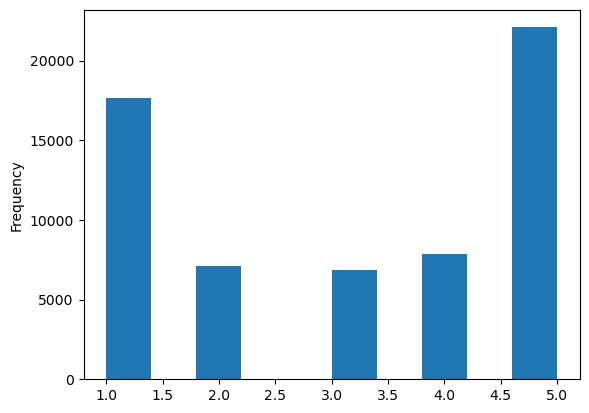

In [8]:
df["Rating"].plot(kind="hist")

**Most of the reviewers are either most satisfied or most disatisfied with the app**

**Majority of the reviewrs are satisfied with the app**

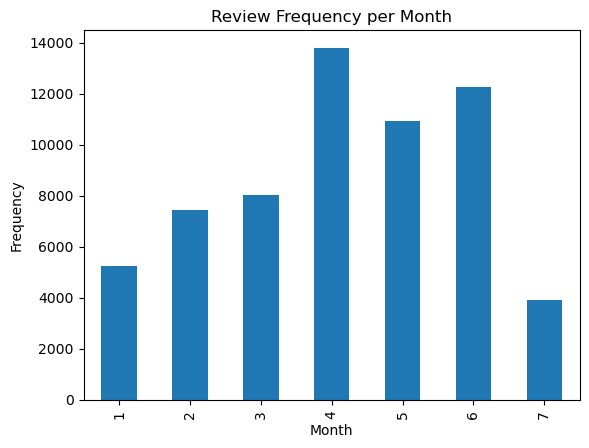

In [9]:
df['Time_submitted'].dt.month.value_counts().sort_index().plot(kind='bar')

plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Review Frequency per Month')

plt.show()

**The Reviews are well distributed among the months**

In [10]:
# removing non alphabet symbols
def clean_text(text):
    text = re.sub("[^a-zA-Z']+", ' ', text)
    
   
    words = [word for word in text.split() if re.match("^[a-zA-Z']+$", word)]
    return ' '.join(words)

# apply the function to create a new column in the dataframe
df['Review'] = df['Review'].apply(clean_text)

<Axes: ylabel='Frequency'>

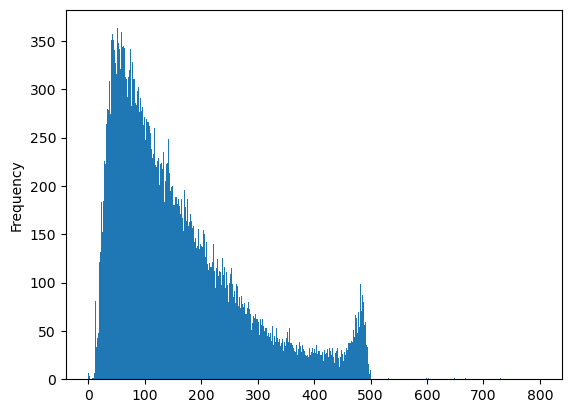

In [11]:
df["len"] = df["Review"].apply(len)
df["len"].plot(kind="hist", bins=range(0, 800))


**Seems like the dataset is clean now and good to go for data analysis**

## Tokenization

### Collect candidate term phrases 

candidate phrases are sets of words that have a higher probability of being meaningful and relevant compared to individual words.

In [12]:
import spacy
from spacy.matcher import Matcher

In [13]:

nlp = spacy.load(
    "en_core_web_sm",
    exclude=[ "parser", "ner", "lemmatizer", "attribute_ruler"],
)

In [14]:
matcher = Matcher(nlp.vocab)
matcher.add(
    "Term",
    [
        [
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP"]}},
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP", "HYPH"]}, "OP": "*"},
            {"TAG": {"IN": ["NN", "NNS", "NNP"]}},
        ]
    ],
)

In [15]:
# defining function to apply the matcher to a spaCy doc object
def get_phrases(doc):
    spans = matcher(doc, as_spans=True)
    return [tuple(tok.norm_ for tok in span) for span in spans]

The code defines a function get_phrases that takes a document doc as input and returns a list of phrases extracted from it.


In [16]:
candidates = list(
    concat(map(get_phrases, nlp.pipe(tqdm(df["Review"]), batch_size=20, n_process=4)))
)

  0%|          | 0/61594 [00:00<?, ?it/s]

In [17]:
import pickle

with open("candidate_spotify.pkl", "wb") as out:
    pickle.dump(candidates, out)

In [18]:
from collections import defaultdict

freqs = defaultdict(nltk.FreqDist)
for c in candidates:
    freqs[len(c)][c] += 1

### Extract terms

In [19]:
def get_subterms(term):
    k = len(term)
    for m in range(k - 1, 1, -1):
        yield from nltk.ngrams(term, m)


def c_value(F, theta):

    termhood = nltk.FreqDist()
    longer = defaultdict(list)

    for k in sorted(F, reverse=True):
        for term in F[k]:
            if term in longer:
                discount = sum(longer[term]) / len(longer[term])
            else:
                discount = 0
            c = np.log2(k) * (F[k][term] - discount)
            if c > theta:
                termhood[term] = c
                for subterm in get_subterms(term):
                    if subterm in F[len(subterm)]:
                        longer[subterm].append(F[k][term])
    return termhood

# **Text Analysis on Reviews**

## **Terms**

In [20]:
terms = c_value(freqs, theta=50)

In [21]:
terms.most_common(15) 

[(('music', 'app'), 2275.125),
 (('great', 'app'), 1670.0),
 (('good', 'app'), 1631.0),
 (('many', 'ads'), 936.0),
 (('new', 'update'), 898.0),
 (('last', 'update'), 694.0),
 (('internet', 'connection'), 666.0),
 (('favorite', 'songs'), 625.0),
 (('great', 'music'), 552.5),
 (('random', 'songs'), 544.0),
 (('free', 'version'), 534.0),
 (('other', 'apps'), 479.0),
 (('recent', 'update'), 460.0),
 (('joe', 'rogan'), 439.0),
 (('amazing', 'app'), 435.0)]

## Conclusion
**The terms like music app, great app are expected. But the terms to take into considerations are many ads, updates, internet connection, free version, other apps.which convey that Most of the people are satisfied with the app. But there are some improvements to be made like reducing the number of ads, updating the app in such a way that it becomes user friendly. Improving the app with respect to free versions, updates helps the app in gaining more customers.**

In [22]:
terms.most_common()[-15:]

[(('joe', 'rogan', 'experience'), 53.8887250245193),
 (('free', 'users'), 53.0),
 (('free', 'user'), 53.0),
 (('ads', 'ads'), 53.0),
 (('past', 'few', 'days'), 52.30376252379815),
 (('premium', 'family'), 52.0),
 (('favorite', 'podcasts'), 52.0),
 (('pc', 'version'), 52.0),
 (('bluetooth', 'devices'), 52.0),
 (('only', 'complaint'), 52.0),
 (('similar', 'songs'), 51.0),
 (('free', 'premium'), 51.0),
 (('spotify', 'user'), 51.0),
 (('old', 'spotify'), 51.0),
 (('nice', 'music', 'app'), 50.718800023076994)]

## Conclusion
**Joe Rogan is an American comedian, podcaster, and UFC commentator. Most of the users are talking about his content.If the content created by Joe Rogan is well organized and managed the app could make the customers more satisfied**

In [23]:
with open('terms_Spotify.txt', 'w') as f:
    for term in terms:
        print(' '.join(term), file=f)

### Multi-word tokenizer

In [24]:
from spacy.matcher import PhraseMatcher
from spacy.util import filter_spans

In [25]:
nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)
phraser = PhraseMatcher(nlp.vocab, attr="LOWER")

In [26]:
with open('terms_Spotify.txt', 'r') as f:
    phraser.add("TERM", [nlp.tokenizer(t.strip()) for t in f])

In [27]:
def tokenize(text, sep="_"):
    doc = nlp.tokenizer(text)
    with doc.retokenize() as r:
        for span in filter_spans(phraser(doc, as_spans=True)):
            r.merge(span)
    return [t.norm_.replace(" ", sep) for t in doc if not t.is_space and not t.is_punct]

## **Word clouds**¶
In this  section, the tokenizer is used to  make some word clouds comparing good and bad Reviews 

In [28]:
total = nltk.FreqDist(concat(df["Review"].apply(tokenize)))
bad = nltk.FreqDist(concat(df.query("Rating < 3")["Review"].apply(tokenize)))
good = nltk.FreqDist(concat(df.query("Rating > 3")["Review"].apply(tokenize)))

In [29]:
good.most_common(5)

[('i', 31477), ('the', 25821), ('to', 23423), ('it', 21469), ('and', 19273)]

In [30]:
metrics = nltk.BigramAssocMeasures()

In [31]:
bad_pmi = nltk.FreqDist()

for w in bad:
    if bad[w] > 15:
        bad_pmi[w] = metrics.pmi(bad[w], (total[w], bad.N()), total.N())

In [32]:
bad_pmi.most_common(10)

[('dogshit', 1.0120397520573086),
 ('unauthorized', 1.0120397520573086),
 ('useable', 1.0120397520573086),
 ('stupid_app', 0.9906661012647433),
 ('lisa', 0.9900134457273069),
 ('garbage_app', 0.9860445435243612),
 ('terrible_app', 0.9725113878706715),
 ('restricting', 0.9614136789873413),
 ('horrendous', 0.9595723321631731),
 ('ridiculously', 0.9595723321631731)]

In [33]:
def cloud(freqs, title, k=40):
    plt.figure(figsize=(8, 8))
    wc = WordCloud(
        width=750, height=750, background_color="black"
    ).generate_from_frequencies(freqs)
    plt.title(title)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

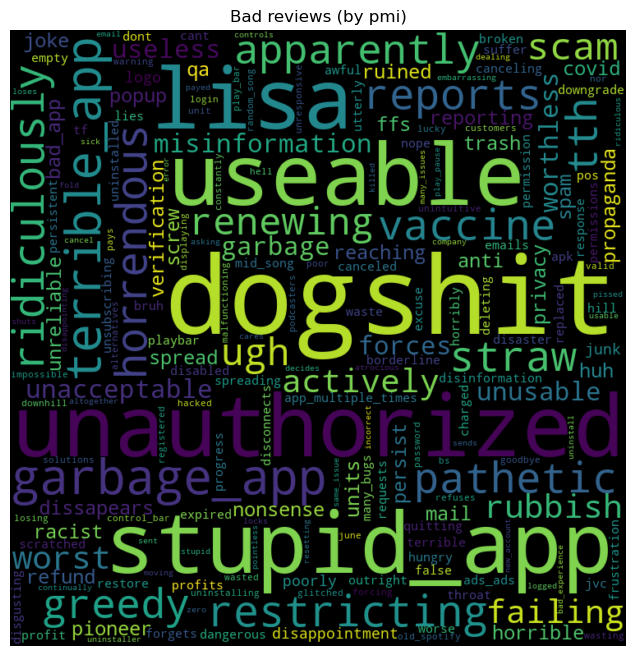

In [34]:
cloud(bad_pmi, "Bad reviews (by pmi)")

In [35]:
pd.set_option("display.max_colwidth", 1000)
stupid_cells = df[df['Review'].str.contains('stupid app')]
print(len(stupid_cells))
stupid_cells.head(7)

52


,Time_submitted,Review,Rating,Total_thumbsup,len
1191,2022-07-07 01:25:30,The only reason i have spotify is for the joe rogan experience and its almost not worth it the app co stantly crashes changes what im listening to the way it works is trash i have to uninstall and re install this stupid app at least twice a month i ho estly cant believe people pay for this trash,1,0,296
1428,2022-07-06 13:32:33,i cant open this app no matter what its stuck literally and the worst thing is have paid for premium i have paid and cant use it just because this stupid app just dont responds i have tried restart reinstall and everything btw this sucks,1,0,237
1861,2022-07-05 15:17:54,No mather what i do it will keep playing I close and it playes again damn stupid app,1,0,84
3189,2022-07-02 15:26:28,Fix your stupid app It's been crashing for months now,1,1,53
5111,2022-06-28 10:54:36,I HATE IT that Spotify has to add their horrible recommendations to my playlist This is absolutely stupid and plays songs from artists I don't even care about I made a playlist to listen to artist only not a mix of unrelated artists No wonder people are deleting your stupid app when you do things like this,1,1,307
6048,2022-06-26 06:59:09,Horrible app you make a playlist and spotify decides to add in the worst songs imaginable you cant get rid of then you do it and it adds other gay songs hoorible app you cant even listen to one song by its self worst music app in the world you only get to skip a few of songs and then your band stupid app fix it for christ sakes,1,0,329
6096,2022-06-26 04:19:08,This stupid app keeps turning itself off in the middle of listening to something and sometimes won't go to the next episode of a podcast,2,0,136


**Conclusion: By analysing the word "stupid app" from reviews, it is clear that people are hating because of its crashing nature.**

In [36]:
lisa_cells = df[df['Review'].str.contains('lisa')]
print(len(lisa_cells))
lisa_cells.head(8)

11


,Time_submitted,Review,Rating,Total_thumbsup,len
2590,2022-07-03 22:04:09,Your app needs a MAJOR redesign The Joe Rogan podcast deal didn't make podcasts better on your app Try a redesign of the UI that makes sense That makes it easier to discover new things Make it a more social and Connected network Some new button deisgns colour schemes symmetry minimalist DARK AND LIGHT MODE I can go on forever Pump that cash into a user friendly design and make it available both for iOS and Android at the same time Give users control windows Xp media player visualisation,2,0,491
3647,2022-07-01 14:08:42,The app is epic I don't mind the ads I just need one thing added and I'd give a start rating no doubt A personalisation option to change the background in the profile to any default color options like blue purple green etc instead of the default ones which most of the time don't match with many users' profile pictures Please try to add this feature,3,449,350
16979,2022-05-29 19:36:26,Very nice one complaint is sometimes it requires you to buy premium to play your personalisation but it's kind of rare so overall amazing platform great songs podcasts and other related items,5,0,191
25050,2022-05-06 13:19:54,Been a user since beta when they were really new and it still feels fresh fast and expanding It needs a light dark mode for PC better implementation off messaging more lyrics UI Themes or customizable layouts with more visualisations so it is pretty chunky in file size cpu usage for being a media player buffering from a connection but so there is still room for improvements,4,8,376
28570,2022-04-27 03:14:38,no imidiate response to complain your system already hack still you dont know a song by lisa of blackpink MONEY been replace by hacker with another artist,1,1,154
28853,2022-04-26 14:01:26,Hey spotify How come money by lisa is place with a different song Fix it ASAP zero rate until you fix it,1,1,104
28882,2022-04-26 13:16:25,Wrost app ever not responding to our problems fix money buy lisa I want to hear that song but not working,1,2,105
28896,2022-04-26 13:03:26,Ive been reporting about lisa's money song having a problem since but spotify seems to just overlook it Please do something about it The app is good but the problem concerns that fans experience on your app like the app suddenly stop music stop and issue with an artist song being replace infringe and spotify slow action are making the experience of the paid app not so fun Gonna change my rating if u address the issue,1,1,420


In [37]:
unautorized_cells = df[df['Review'].str.contains('unauthorized')]
print(len(unautorized_cells))
unautorized_cells.head(8)

15


,Time_submitted,Review,Rating,Total_thumbsup,len
28502,2022-04-27 06:27:48,We noticed that the song MONEY by LISA on some of your playlist has been replaced with unauthorized song with an identical name we are sending alot of reports but still disappointed for this matter i hope this issue wont take long,1,0,230
28699,2022-04-26 19:53:46,Money by Lisa has been replaced with an unauthorized song with identical name It's been days but you keep ignoring the fans You are not doing immediate action to fix this problem Are you really busy enough It's been days and no respond,1,0,235
28790,2022-04-26 15:42:27,We noticed that the song 'MONEY' by LISA on some of your playlists including TTH has been replaced with an unauthorized song with an identical name Pls fix this asap,1,2,165
28810,2022-04-26 15:06:47,Money by Lisa on the other playlist was replace by an unauthorized song Fix this issue ASAP,1,3,91
28828,2022-04-26 14:40:22,'Money' by LISA is replaced by a unauthorized song in Today's Top Hit playlist This is happening in many other playlists too LISA fanbase are trying to reach spotify service but no one is answering Because of this issue 'Money' dropped from global today It is affecting the streaming number of the song too Please fix this issue,1,4,328
28831,2022-04-26 14:35:14,I'm so disappointed with your service I try to play the artist LISA song MONEY but sadly in some of your playlists the real artist has been replaced with an unauthorized song with an identical name We have been waiting for days you to fix this but seems like no response from you Hope you will fix this very soon,1,2,312
28843,2022-04-26 14:14:55,The issue on your playlists including TTH where 'MONEY' by LISA has been replaced with an unauthorized song with an identical name is still not fixed Please rectify this,1,1,169
28850,2022-04-26 14:05:26,The song 'MONEY' by LISA on some of your playlists especially from TTH and playlist with million followers has been replaced with an unauthorized song with an identical name We have been reporting about that through email twitter and instagram since April and you guys still didn't fixed SO DISAPPOINTING,1,2,304


**Conclusion: Again it is about the "Money" song by Lisa, which is replaced by an unauthorized song**

In [38]:
restricting_cells = df[df['Review'].str.contains('restricting')]
print(len(restricting_cells))
restricting_cells.head(8)

23


,Time_submitted,Review,Rating,Total_thumbsup,len
518,2022-07-08 11:45:54,WAYYY to restricting This app annoys me because its literally Forcing me to buy premium I shuffle in my playlist and it plays a completely different song i havent put in my playlist Its so annoying that i have to shuffle in order to get the song i want to play cause if i click a song it doesn't even play it I dont even get the song i wanna play I only get skips per hour and the updates they make are a HUGGEEE downgrade Im done with this app,1,0,444
950,2022-07-07 14:03:22,couldve been a good app if it werent so restricting its decent in windows but in mobile god this app is the worst too much lag needs premium for everything and plays random songs you dont put in your playlist you cant loop a song in mobile either,2,0,246
2991,2022-07-03 01:41:44,It used to be great but now it's restricting and quite unusable it's forcing us users to go premium if you don't change it like before I will delete this app,2,0,157
3877,2022-07-01 01:18:12,I like the app But why have you been restricting Neil Young songs,5,0,65
4241,2022-06-30 06:44:57,It's a good app for listening music but it's too restricting when i play my fav song it automatically played another song which is not in my playlist,1,0,149
4973,2022-06-28 16:24:47,Why is the app version restricting than the desktop version skips per hour and it doesnt even play songs in the playlist that I created it plays songs randomly,1,0,159
5615,2022-06-27 09:32:11,I swear its too restricting spotify was a lot better before the update,1,0,70
6446,2022-06-25 07:41:25,star is too much for this app it should be cause it's too restricting it's very disapointing i can't even play a song that i want I don't like the update,1,0,153


**Conclusion: Seems like Reviwers are restricted from using app as they like.  Like playing their favorite song,forcing to buy premium,etc**

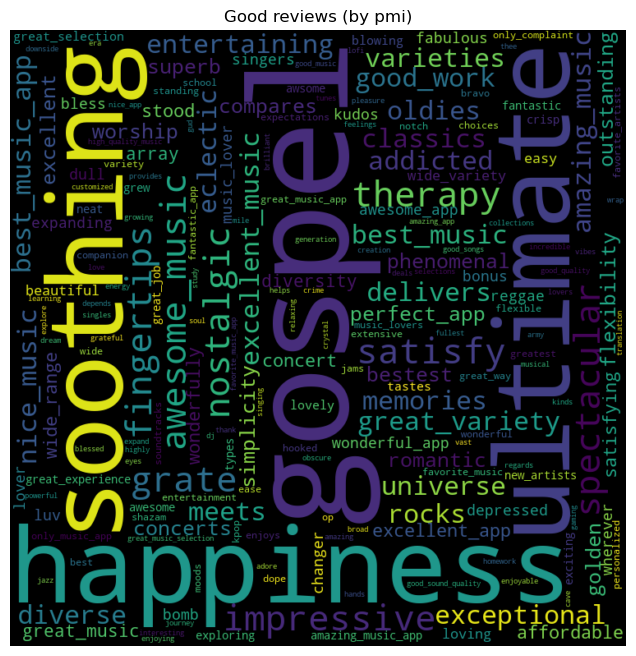

In [39]:
good_pmi = nltk.FreqDist()

for w in good:
    if good[w] > 10:
        good_pmi[w] = metrics.pmi(good[w], (total[w], good.N()), total.N())

cloud(good_pmi, "Good reviews (by pmi)")

In [80]:
good_pmi.most_common(10)

[('gospel', 1.4356505370153982),
 ('happiness', 1.4356505370153982),
 ('ultimate', 1.4356505370153982),
 ('soothing', 1.4356505370153982),
 ('impressive', 1.4356505370153947),
 ('therapy', 1.4356505370153947),
 ('satisfy', 1.4356505370153947),
 ('grate', 1.4356505370153947),
 ('spectacular', 1.4356505370153947),
 ('nostalgic', 1.4356505370153947)]

In [40]:
gospel_cells = df[df['Review'].str.contains('gospel')]
print(len(gospel_cells))
gospel_cells.head(8)

27


,Time_submitted,Review,Rating,Total_thumbsup,len
8694,2022-06-20 09:47:42,Brilliant App very functional and apt for the gospel music uses I desire of it etc,5,0,82
10774,2022-06-15 13:58:56,I absolutely love this station since get the enjoyment of the kind of music I like I love gospel and oldies are my go to but there are other types I like and the choices are endless,5,0,181
14496,2022-06-05 20:43:37,Good morning When I first got hooked up with Spotify love it to be truthful about it l just got to have it all day and GOD knows l need it l listen to the new young Christian gospel song amen good stuff,5,0,202
14538,2022-06-05 17:30:57,Lovely gospel music sound quality is amazing,5,0,44
15538,2022-06-02 20:25:02,Always love music especially gospel,5,0,35
15658,2022-06-02 13:34:50,Good need more gospel and spiritual music,5,0,41
16957,2022-05-29 20:55:24,Love everything everything I can listen to gospel music all day long,5,0,68
18391,2022-05-25 23:34:25,I love spotify have a many kind of gospel song that i realy like,4,0,64


**Conclusion:Gospel is referred in many contexts like music,experience,song,etc**

In [41]:
satisfy_cells = df[df['Review'].str.contains('satisfy')]
print(len(satisfy_cells))
satisfy_cells.head()

44


,Time_submitted,Review,Rating,Total_thumbsup,len
2125,2022-07-05 00:29:48,Love this app Whatever mood I am in Spotify can satisfy my music craving I just wish I knew how to stop my notifications from interrupting my songs,5,0,147
2454,2022-07-04 07:46:01,Please removes the add Except this i am fully satisfy with spotify,4,0,66
5099,2022-06-28 11:27:52,I love this app very much I really recommend this app to music lovers it's really satisfy to listen songs in this app thank you,5,0,127
7614,2022-06-22 16:50:42,This makes you feel better when you are not feeling ok means when you are sad it can easily make you happy by songs There are also sad songs but it is very satisfying app I like it very much After downloading this app you will be very happy Thanks for makin this app,5,0,266
8824,2022-06-19 23:52:47,Cool stress less and satisfying,5,0,31


**Conclusion: Reviewers are using the word "satisfy" with different contexts like music, app, personal feeling,etc**

In [42]:
finger_tips_cells = df[df['Review'].str.contains('finger tips')]
print(len(finger_tips_cells))
finger_tips_cells.head()

17


,Time_submitted,Review,Rating,Total_thumbsup,len
5310,2022-06-27 22:33:12,Absolutely invaluable Where else can you have at your finger tips a world of music pod casts and more Absolutely invaluable,5,0,123
5800,2022-06-26 20:23:35,Love Spotify has all my favorite music at the tap of my finger tips,5,0,67
17730,2022-05-27 23:16:17,Think of a song and it's at your finger tips Amazing music Recommendations from Spotify are fantastic when they get to know your favourite music Cant Live without Spotify Seriously,5,1,180
18533,2022-05-25 14:58:54,The app is great millions of songs for free at ur finger tips but the thing is its kinda heavy for old and below budget phone like on my galaxy note it lags a lot and sometimes even freez and crash u should really consider making a lite version pllssss,4,0,252
20409,2022-05-19 19:20:30,Music for any mood at your finger tips,4,0,38


**Conclusion: Reviewers are happy that they can listen to their favourite songs at their finger tips**

### **Topic Modeling**

In [43]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(t.strip() for t in open("terms_Spotify.txt"))

In [44]:
df["tokens"] = (df["Review"]).progress_apply(tokenizer.tokenize)

  0%|          | 0/61594 [00:00<?, ?it/s]

### **Estimate LDA**

In [45]:
import tomotopy as tp

In [46]:
k = 50
min_df = 100
rm_top = 70
tw = tp.TermWeight.ONE  # like term f
alpha = 0.1
eta = 0.01
tol = 1e-4  # setting tolerance

In [47]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for doc in df["tokens"]:
    if doc:
        mdl.add_doc(doc)  # creating tdf

mdl.train(0)
last = mdl.ll_per_word  # log likelihood
print(f"{0:5d} LL = {last:8.4f}", flush=True)

for i in range(50, 5000, 50):
    mdl.train(50, workers=4)  # make guesses abt teta 50 times repeat
    ll = mdl.ll_per_word
    print(f"{i:5d} LL = {ll:8.4f}", flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

print(f"Done!")
# getting smalller

    0 LL = -11.2967
   50 LL =  -7.6085
  100 LL =  -7.4462
  150 LL =  -7.3941
  200 LL =  -7.3683
  250 LL =  -7.3464
  300 LL =  -7.3409
  350 LL =  -7.3311
  400 LL =  -7.3233
  450 LL =  -7.3193
  500 LL =  -7.3144
  550 LL =  -7.3098
  600 LL =  -7.3068
  650 LL =  -7.3053
  700 LL =  -7.3061
Done!
CPU times: user 4min 41s, sys: 1.47 s, total: 4min 43s
Wall time: 1min 38s


### Examine the model

In [48]:
", ".join(mdl.removed_top_words)  # delete repeated words

"i, the, to, it, and, not, a, is, app, my, for, of, you, this, but, have, can, music, that, 's, spotify, on, in, songs, song, do, so, with, when, like, play, just, all, listen, are, me, am, will, or, if, love, ads, be, no, even, now, playlist, there, playing, want, premium, has, use, get, they, good, very, please, was, does, your, what, as, really, been, fix, one, from, an, at"

**Nothing important seems removed, we can proceed further.**

In [49]:
# LDA viz
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.manifold import MDS, TSNE


def plot_topics(mdl, method="tsne", figsize=7):

    fig = plt.figure(figsize=(figsize, figsize))

    # x, y coords
    term_topics_dist = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    if method == "mds":
        dist = distance.squareform(distance.pdist(term_topics_dist, "jensenshannon"))
        coords = MDS(2, dissimilarity="precomputed").fit_transform(dist)
    elif method == "tsne":
        if mdl.k <= 20:
            p = mdl.k - 1
        else:
            p = 20
        coords = TSNE(
            2,
            metric=distance.jensenshannon,
            perplexity=p,
            init="pca",
            learning_rate="auto",
            n_jobs=-1,
        ).fit_transform(term_topics_dist)
    else:
        raise ValueError(f"Method {method} unknown")

    # size of the circle
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    words_per_topic = np.dot(doc_topic_dists.T, doc_lengths)
    topic_percent = words_per_topic / words_per_topic.sum()
    sizes = topic_percent * (figsize * fig.dpi) * (figsize * fig.dpi) * (0.25 / 3.14)

    # draw it
    plt.scatter(coords[:, 0], coords[:, 1], s=sizes, alpha=0.3)
    for i in range(mdl.k):
        plt.text(coords[i, 0], coords[i, 1], i, ha="center", va="center")

        plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

In [50]:
np.random.seed(123)

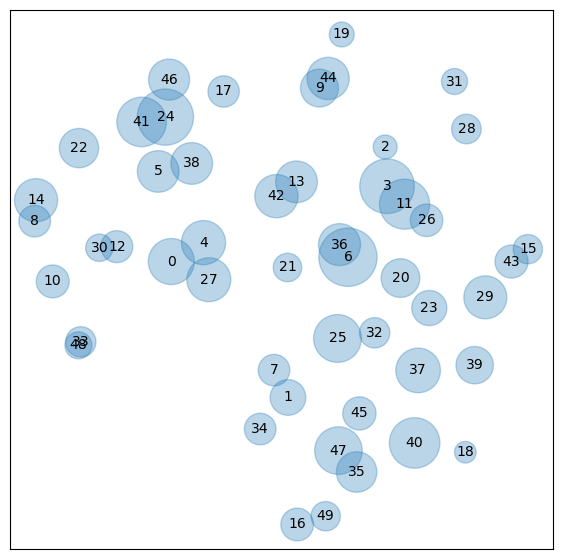

In [51]:
plot_topics(mdl)  # with 50 topics for reviews

**The most common topic numbers are -6,36;24,41;3,11;40,37,29,47**

### Interpret the model

In [52]:
for k in range(mdl.k):
    print(
        f"{k:3d} ", ", ".join(s for s, _ in mdl.get_topic_words(k))
    )  # each cluster says abt topic
    # topic 42, 8, 26 slly to eachother

  0  working, after, fine, then, ago, had, update, again, until, work
  1  find, could, old, here, any, new, time, every, found, everything
  2  over, shuffle, same_songs, same, again, plays, hear, only, repeat, radio
  3  plays, then, click, another, try, because, search, album, only, let
  4  issues, fixed, having, issue, problems, problem, bugs, these, had, soon
  5  time, crashes, load, sometimes, work, takes, open, slow, buggy, constantly
  6  about, people, know, their, who, by, money, how, would, because
  7  everything, else, find, every, something, about, anything, any, great, always
  8  wifi, internet, internet_connection, connection, offline, says, working, connected, fine, shows
  9  ad, minutes, after, every, then, more, mins, free, time, two
 10  problem, try, open, something, issue, again, any, whenever, wrong, after
 11  only, skip, skips, hour, shuffle, per, without, pay, hate, pick
 12  phone, uninstalled, still, uninstall, reinstalled, reinstall, again, nothing, wor

In [53]:
mdl.save("Spotify_topics.bin")

In [54]:
topic_words = [[x for x, _ in mdl.get_topic_words(i)] for i in range(mdl.k)]
topics = pd.DataFrame(
    {
        "label": [x[0].upper() for x in topic_words],
        "words": [", ".join(x) for x in topic_words],
    }
)
topics.to_csv("Slabels.csv", index=False)
# labelling topics / generating intial labels

In [55]:
topics

,label,words
0,WORKING,"working, after, fine, then, ago, had, update, again, until, work"
1,FIND,"find, could, old, here, any, new, time, every, found, everything"
2,OVER,"over, shuffle, same_songs, same, again, plays, hear, only, repeat, radio"
3,PLAYS,"plays, then, click, another, try, because, search, album, only, let"
4,ISSUES,"issues, fixed, having, issue, problems, problem, bugs, these, had, soon"
5,TIME,"time, crashes, load, sometimes, work, takes, open, slow, buggy, constantly"
6,ABOUT,"about, people, know, their, who, by, money, how, would, because"
7,EVERYTHING,"everything, else, find, every, something, about, anything, any, great, always"
8,WIFI,"wifi, internet, internet_connection, connection, offline, says, working, connected, fine, shows"
9,AD,"ad, minutes, after, every, then, more, mins, free, time, two"


# Conclusion:
**Most common topic numbers are - 6,36;24,41;3,11;40,37,29,47corresponding to the topics-ABOUT,HOW, STOP,UPDATE;PLAYS,ONLY;PLAYLISTS,THAN-(comparing), ADD,LISTENING**

**And their topic words are as follows**
- ABOUT- about, people, know, their, who, by, money, how, would, because
- HOW- how, why, out, up, know, back, go, because, make, keep
- STOP-  stop, close, pause, randomly, stops, again, sometimes, keeps, force, restart
- UPDATE- update, pause, skip, latest, up, show, stop, bar, controls, player
- PLAYS-  plays, then, click, another, try, because, search, album, only, let
- ONLY-  only, skip, skips, hour, shuffle, per, without, pay, hate, pick
- PLAYLISTS-  playlists, artists, find, artist, also, how, make, easy, new, listening
- THAN-   than, better, more, much, other, would, way, youtube, wish, pandora
- ADD-  add, back, feature, why, preview, adding, before, button, playlists, removed
- LISTENING- listening, best, enjoy, favorite, thank, much, thanks, easy, amazing, good_app

**Among these the most important topics are as follows:** 
- STOP and UPDATE which are talking about the controls of the app like, start, pause, stop, restart- there might be something wrong with the controls of app
- PLAYLISTS which is talking about the playlists made by spotify app. Users might be liking the playlists
- THAN indicating that users are comparing the app with someother alternatives like pandora, mentioned in the words. It is a popular online music streaming and automated music recommendation service.
- LISTENING- positive words are observed for this topic

In [57]:
from collections import Counter
import tomotopy as tp
from tqdm.auto import tqdm

tqdm.pandas()

In [58]:
mdl = tp.LDAModel.load("Spotify_topics.bin")  # loading lda model and csv
Slabels = list(pd.read_csv("Slabels.csv")["label"])

### Apply topic model

In [78]:
#Removing empty rows
empty_rows = []
for i, toks in enumerate(df["tokens"]):
    # Check if the list of tokens is empty
    if not toks:
        # If the list of tokens is empty, append the index to the list of empty rows
        empty_rows.append(i)
# Print the indices of empty rows
print("Empty rows:", empty_rows)

Empty rows: []


In [60]:
df.iloc[4722], df.iloc[5610]

(Time_submitted    2022-06-29 06:05:15
 Review              ' ' ' ' ' ' ' ' '
 Rating                              1
 Total_thumbsup                      0
 len                                17
 tokens                             []
 Name: 4722, dtype: object,
 Time_submitted    2022-06-27 09:48:04
 Review                              '
 Rating                              5
 Total_thumbsup                      1
 len                                 1
 tokens                             []
 Name: 5610, dtype: object)

In [61]:
df.drop(df.index[[4722, 5610, 5694, 10044, 13587, 18045, 21653, 26260, 26963, 39823, 42643]],inplace=True)

In [62]:
df["doc"] = [mdl.make_doc(words=toks) for toks in df["tokens"]]
df["doc"].head()

0    (great_music, service, the, audio, is, high_quality, and, the, app, is, easy, to, use, also, very, quick, and, friendly, support)
1                                  (please, ignore, previous, negative, rating, this, app, is, super, great, i, give, it, five, stars)
2            (this, pop, up, get, the, best, spotify, experience, on, android, is, too, annoying, please, let, us, get, rid, of, this)
3                                                                            (really, buggy, and, terrible, to, use, as, of, recently)
4               (dear, spotify, why, do, i, get, songs, that, i, do, not, put, on, my, playlist, and, why, do, we, have, shuffle_play)
Name: doc, dtype: object

## Analysing the reviews with rating=1 with Topic modeling
**what are the most common topics associated with rating 1?**

In [63]:
df1 = df.query("Rating==1").copy()
df1["Rating"].value_counts()

1    17651
Name: Rating, dtype: int64

In [64]:
df1.head()

,Time_submitted,Review,Rating,Total_thumbsup,len,tokens,doc
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,47,"[really, buggy, and, terrible, to, use, as, of, recently]","(really, buggy, and, terrible, to, use, as, of, recently)"
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't put on my playlist And why do we have shuffle play,1,1,96,"[dear, spotify, why, do, i, get, songs, that, i, do, not, put, on, my, playlist, and, why, do, we, have, shuffle_play]","(dear, spotify, why, do, i, get, songs, that, i, do, not, put, on, my, playlist, and, why, do, we, have, shuffle_play)"
9,2022-07-09 13:11:32,I'm deleting this app for the following reasons This app now has a failing business model Whether streaming services like it or not the consumer doesn't want to pay for music they can't fully own and ads successively upon logging in before a single song is too much Closed the app during ad number and I'm more patient than most If those are the only ways you can profit you've already peaked All that's left is your decline,1,318,424,"[i, am, deleting, this, app, for, the, following, reasons, this, app, now, has, a, failing, business, model, whether, streaming, services, like, it, or, not, the, consumer, does, not, want, to, pay, for, music, they, can, not, fully, own, and, ads, successively, upon, logging, in, before, a, single_song, is, too, much, closed, the, app, during, ad, number, and, i, am, more, patient, than, most, if, those, are, the, only, ways, you, can, profit, you, have, already, peaked, all, that, 's, left, is, your, decline]","(i, am, deleting, this, app, for, the, following, reasons, this, app, now, has, a, failing, business, model, whether, streaming, services, like, it, or, not, the, consumer, does, not, want, to, pay, for, music, they, can, not, fully, own, and, ads, successively, upon, logging, in, before, a, single_song, is, too, much, closed, the, app, during, ad, number, and, i, am, more, patient, than, most, if, those, are, the, only, ways, you, can, profit, you, have, already, peaked, all, that, 's, left, is, your, decline)"
11,2022-07-09 13:10:50,Can't play Spotify when on WiFi,1,1,31,"[can, not, play, spotify, when, on, wifi]","(can, not, play, spotify, when, on, wifi)"
12,2022-07-09 13:09:56,I had amazon premium music family package and it was good Everyone could listen to whatever they liked on their respective alexas in their rooms by just asking to play no problem We now have spotify premium family and the alexa integration is poor It just doesn't like spotify It just stops playing all of the time you can't play on different alexa devices at the same time just by asking Why isn't the integration better,1,7,421,"[i, had, amazon, premium, music, family, package, and, it, was, good, everyone, could, listen, to, whatever, they, liked, on, their, respective, alexas, in, their, rooms, by, just, asking, to, play, no, problem, we, now, have, spotify_premium, family, and, the, alexa, integration, is, poor, it, just, does, not, like, spotify, it, just, stops, playing, all, of, the, time, you, can, not, play, on, different, alexa, devices, at, the, same_time, just, by, asking, why, is, not, the, integration, better]","(i, had, amazon, premium, music, family, package, and, it, was, good, everyone, could, listen, to, whatever, they, liked, on, their, respective, alexas, in, their, rooms, by, just, asking, to, play, no, problem, we, now, have, spotify_premium, family, and, the, alexa, integration, is, poor, it, just, does, not, like, spotify, it, just, stops, playing, all, of, the, time, you, can, not, play, on, different, alexa, devices, at, the, same_time, just, by, asking, why, is, not, the, integration, better)"


In [65]:
topic_dist_1, ll_1 = mdl.infer(df1["doc"])# applying topic mdl

### Interpret model


In [66]:
df1["topics"] = [
    [Slabels[t] for t in map(first, d.get_topics(3))] for d in df1["doc"]
]

In [67]:
df1["topics"]
# mapping each review to top 3 topics

3            [TIME, LISTENING, ABOUT]
4                 [ADD, U, LISTENING]
9            [JOE_ROGAN, AFTER, THAN]
11           [WIFI, LISTENING, ABOUT]
12       [SUBSCRIPTION, ABOUT, AFTER]
                     ...             
61586          [ONLY, ABOUT, PODCAST]
61587       [LISTENING, ABOUT, AFTER]
61588            [ISSUES, ADD, PLAYS]
61589         [LYRICS, THAN, PROBLEM]
61590                 [PAY, ABOUT, U]
Name: topics, Length: 17651, dtype: object

In [68]:
topic_freq = Counter(concat(df1["topics"]))
print(len(topic_freq.most_common()))
topic_freq.most_common(7)
# most common topics of reviews with rating=1

48


[('LISTENING', 4200),
 ('ABOUT', 3855),
 ('PLAYS', 2624),
 ('STOP', 2331),
 ('UPDATE', 2079),
 ('WORKING', 2045),
 ('PHONE', 1855)]

## Conclusion on Reviews with Rating 1
**And their topic words are as follows:**

- ABOUT- about, people, know, their, who, by, money, how, would, because
- STOP- stop, close, pause, randomly, stops, again, sometimes, keeps, force, restart
- UPDATE- update, pause, skip, latest, up, show, stop, bar, controls, player
- PLAYS- plays, then, click, another, try, because, search, album, only, let
- WORKING-working, after, fine, then, ago, had, update, again, until, work
- PHONE- phone, car, bluetooth, connect, devices, works, device, work, google, using
- LISTENING- listening, best, enjoy, favorite, thank, much, thanks, easy, amazing, good_app

**Among these the most important topics where users are not satisfied are as follows:**

STOP and UPDATE which are talking about the controls of the app like, start, pause, stop, restart- there might be something wrong with the controls of app. The app needs to improve its interface.

WORKING- which is talking that the app is not performing well after the updates. This issue should be rectified by the app developers.

PHONE- the topic words of this topic conveys that there is a problem in connecting with other devices. This should be fixed.

## Analysing the reviews with rating=5 with Topic modeling

**What are the most common topics associated with Rating 5?**

In [69]:
df5 = df.query("Rating==5").copy()
df5["Rating"].value_counts()

5    22086
Name: Rating, dtype: int64

In [70]:
df5.head()

,Time_submitted,Review,Rating,Total_thumbsup,len,tokens,doc
0,2022-07-09 15:00:00,Great music service the audio is high quality and the app is easy to use Also very quick and friendly support,5,2,109,"[great_music, service, the, audio, is, high_quality, and, the, app, is, easy, to, use, also, very, quick, and, friendly, support]","(great_music, service, the, audio, is, high_quality, and, the, app, is, easy, to, use, also, very, quick, and, friendly, support)"
1,2022-07-09 14:21:22,Please ignore previous negative rating This app is super great I give it five stars,5,1,83,"[please, ignore, previous, negative, rating, this, app, is, super, great, i, give, it, five, stars]","(please, ignore, previous, negative, rating, this, app, is, super, great, i, give, it, five, stars)"
6,2022-07-09 13:19:21,I love the selection and the lyrics are provided with the song you're listening to,5,0,82,"[i, love, the, selection, and, the, lyrics, are, provided, with, the, song, you, are, listening, to]","(i, love, the, selection, and, the, lyrics, are, provided, with, the, song, you, are, listening, to)"
8,2022-07-09 13:16:49,It's a great app and the best mp music app I have ever used but there is one problem that why can't we play some songs or find some songs despite this the app is wonderful I recommend it it's just the best,5,0,205,"[it, 's, a, great_app, and, the, best, mp, music_app, i, have, ever, used, but, there, is, one, problem, that, why, can, not, we, play, some, songs, or, find, some, songs, despite, this, the, app, is, wonderful, i, recommend, it, it, 's, just, the, best]","(it, 's, a, great_app, and, the, best, mp, music_app, i, have, ever, used, but, there, is, one, problem, that, why, can, not, we, play, some, songs, or, find, some, songs, despite, this, the, app, is, wonderful, i, recommend, it, it, 's, just, the, best)"
14,2022-07-09 13:08:32,i hav any music that i like it is super,5,0,39,"[i, hav, any, music, that, i, like, it, is, super]","(i, hav, any, music, that, i, like, it, is, super)"


In [71]:
topic_dist_5, ll_5 = mdl.infer(df5["doc"])# applying topic mdl

### Interpret model

In [72]:
df5["topics"] = [
    [Slabels[t] for t in map(first, d.get_topics(3))] for d in df5["doc"]
]

In [73]:
topic_freq = Counter(concat(df5["topics"]))
print(len(topic_freq.most_common()))
topic_freq.most_common(7)
# most common topics of reviews with rating=1

48


[('LISTENING', 13197),
 ('ABOUT', 7953),
 ('EASY', 4668),
 ('SOME', 3077),
 ('PLAYLISTS', 2902),
 ('EVER', 2538),
 ('YEARS', 1950)]

## Conclusion on Reviews with Rating 5
**And their topic words are as follows:**

- LISTENING- listening, best, enjoy, favorite, thank, much, thanks, easy, amazing, good_app
- ABOUT- about, people, know, their, who, by, money, how, would, because
- EASY- easy, great, podcasts, selection, great_app, excellent, great_music, sound, lots, awesome
- SOME- some, its, great, good_app, sometimes, annoying, pretty, great_app, overall, other
- PLAYLISTS-playlists, find, artists, great, also, make, listening, able, how, new
- EVER- ever, best, best_music_app, best_music, streaming, worst, used, far, out, apps
- YEARS- years, had, using, never, used, since, any, over, problems, always


**Among these the most important topics where users are statisfied are as follows:**

- EASY: The users are happy with the spotify podcasts. Concentrating more on podcasts might help in attracting more customers.
- PLAYLISTS: The playlists made by the app according to the user previous listened songs worked well. The users are satisfied with this feature.
- EVER: The words in ever indicates that the reviewers are praising the app.
